<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/%E3%83%9E%E3%83%8F%E3%83%A9%E3%83%8E%E3%83%93%E3%82%B9%E8%B7%9D%E9%9B%A2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# マハラノビス距離による異常検知
多変数の場合は，変数同士の偏りや相関が生じている場合があります。このとき，単純に距離で評価をすると偏りや相関の影響を受けて各変数に対する異常検知の精度も偏ります。この場合，各軸の相関を正規化することによって，パラメータ間の依存関係をキャンセルした距離で評価します。偏りを正規化する簡単な方法として，マハラノビス距離を用いる方法とPCA（主成分分析）を行う方法があります。マハラノビス距離は，データの各軸の分散・共分散行列を用いてデータの偏りを正規化します。PCAは直交化によってより少ない空間の次元で評価します。PCA 後のすべての主成分を用いて，主成分を標準化したサンプルの距離はマハラノビス距離と等価な結果になります。（ただしこのプログラムでは2次元⇒2次元なので次元削減の効果はありません)



In [ ]:
from scipy.spatial import distance #様々な距離関数のライブラリ https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
from sklearn.decomposition import PCA #PCA  https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
import matplotlib.pyplot as plt
import numpy as np

## ダミーデータの作成

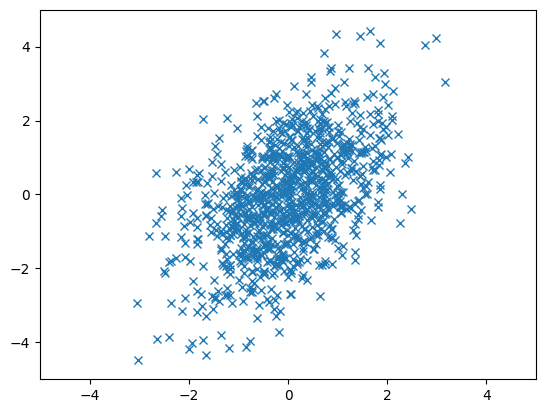

In [ ]:
dnum=1000
mean = np.array([0, 0]) # 平均
cov = np.array([[1, 0.7],[0.7, 2]]) # 共分散行列 わざと少し偏らせたダミーデータ
x, y = np.random.multivariate_normal(mean, cov, dnum).T #多変量正規分布に従う乱数を生成
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.plot(x,y,"x")
plt.show()

## ダミーデータをそのままつかって，平均値からの距離をもとに異常を判定する

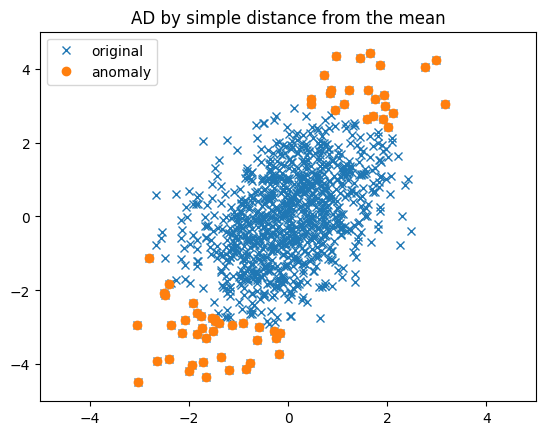

In [ ]:
th= 3 #ここは適宜決定
ano=[]
for i in range(dnum):
# 平均値からの距離をもとに閾値を超えるサンプルを見つける
    d=distance.euclidean([x[i], y[i]],mean)
    if d >=th:
        ano.append([x[i], y[i]])
ano = np.array(ano)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.plot(x,y,"x",label="original")
plt.plot(ano.T[0], ano.T[1],"o",label="anomaly")
plt.title("AD by simple distance from the mean")
plt.legend()
plt.show() #単純に距離だけでは長径側に偏った異常検知になってしまう．．．

## マハラノビス距離を求めて，閾値を超えるサンプルを異常とみなす

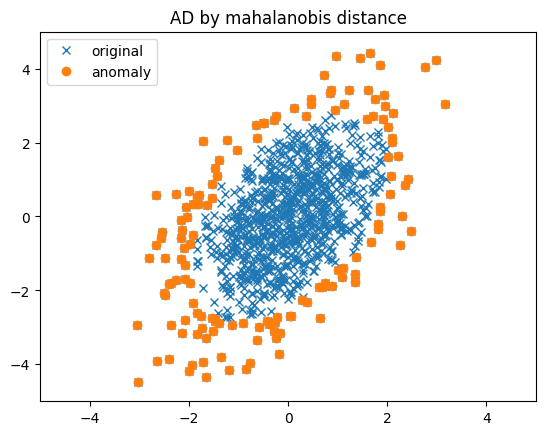

In [ ]:
th= 2.0 #ここは適宜
ano=[]
for i in range(dnum):
# データx, 平均値mean, 共分散行列の逆行列np.linalg.pinv(cov) から距離を計算
    d=distance.mahalanobis([x[i], y[i]], mean, np.linalg.pinv(cov))
    if d >=th:
        ano.append([x[i], y[i]])
ano = np.array(ano)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.plot(x,y,"x",label="original")
plt.plot(ano.T[0], ano.T[1],"o",label="anomaly")
plt.title("AD by mahalanobis distance")
plt.legend()
plt.show() #分布の周辺に沿って異常値が見つかる

## PCAでサンプルを直交化する

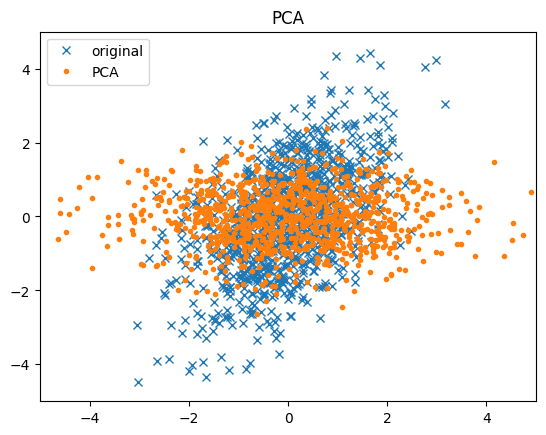

In [ ]:
orgdata=np.array([x,y])
pca=PCA(2)
feature = pca.fit(orgdata.T)
# データを主成分空間に写像
feature = pca.transform(orgdata.T)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.plot(x,y,"x",label="original")
plt.plot(feature.T[0],feature.T[1],".",label="PCA")
plt.title("PCA")
plt.legend()
plt.show()
# 直交化することによりx軸, y軸に沿った分布に変換できる

## PCAで求めた結果に対してマハラノビス距離を求める

mean= [-7.99360578e-18  3.02535774e-18]
cov= [[ 2.41519814e+00 -3.20064295e-17]
 [-3.20064295e-17  6.21476887e-01]]


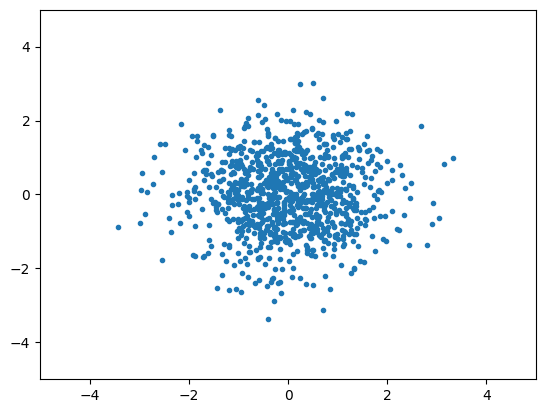

In [ ]:
#PCAに変換した分布パラメータを求めておく
mean2=np.mean(feature,axis=0)
cov2=np.cov(feature,rowvar=0,)
print("mean=",mean2)
print("cov=",cov2)
pcax=(feature.T[0]-mean2[0])/np.sqrt(cov2[0,0])
pcay=(feature.T[1]-mean2[1])/np.sqrt(cov2[1,1])
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.plot(pcax,pcay,".")
plt.show()

0.0 1.0658141036401503e-17


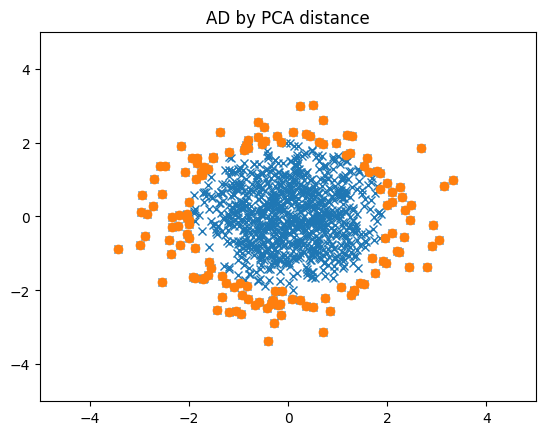

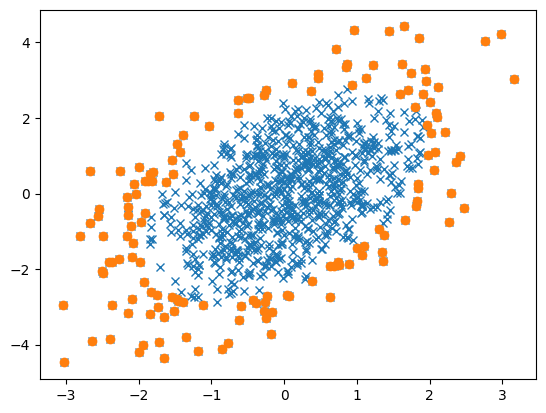

In [ ]:
th= 2.0 #ここは適宜
ano=[]
flag=[]
print(np.mean(pcax),np.mean(pcay))
for i in range(dnum):
# 平均値からの距離をもとに閾値を超えるサンプルを見つける
    d=distance.euclidean([pcax[i], pcay[i]], [np.mean(pcax),np.mean(pcay)])
    if d >=th:
        ano.append([pcax[i], pcay[i]])
        flag.append(1)
    else:
        flag.append(0)
ano = np.array(ano)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.plot(pcax,pcay,"x",label="originalPCA")
plt.plot(ano.T[0], ano.T[1],"o",label="anomaly")
plt.title("AD by PCA distance")
plt.show()

anox=x[(np.array(flag)==1)]
anoy=y[(np.array(flag)==1)]

plt.plot(x,y,"x",label="original")
plt.plot(anox,anoy,"o",label="anomaly")
plt.show()